# Simple CNN for Image Classification

This notebook demonstrates building a simple Convolutional Neural Network (CNN) to classify images from a custom dataset containing 4 classes: **bird**, **car**, **fish**, and **flower**.

## Overview
- **Model**: Simple CNN with 3 convolutional layers and 3 fully connected layers
- **Dataset**: Custom image dataset with 4 classes
- **Framework**: PyTorch
- **Input Size**: 64x64 RGB images

## 1. Import Libraries and Setup

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. Data Preparation

We'll load our custom dataset using the existing train-test split:
- Use pre-split train and test folders from `dataset_split/`
- Resize images to 64x64 pixels
- Convert to tensors
- Normalize using ImageNet statistics
- Create data loaders for efficient batch processing

In [5]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 for better feature extraction
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the train and test datasets from the pre-split folders
train_dataset = datasets.ImageFolder(root='./dataset_split/train', transform=transform)
test_dataset = datasets.ImageFolder(root='./dataset_split/test', transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Classes: {train_dataset.classes}')

# Verify both datasets have the same classes
assert train_dataset.classes == test_dataset.classes, "Train and test datasets must have the same classes"

Training samples: 604
Test samples: 200
Number of classes: 4
Classes: ['bird', 'car', 'fish', 'flower']


## 3. Model Architecture

Our Simple CNN consists of:
- **3 Convolutional Layers**: Extract features from images
- **Max Pooling**: Reduce spatial dimensions
- **3 Fully Connected Layers**: Classification layers
- **Dropout**: Prevent overfitting

In [6]:
# Define the simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):  # 4 classes: bird, car, fish, flower
        super(SimpleCNN, self).__init__()
        # Input channels = 3 (RGB), output channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        # After 3 pooling operations: 64x64 -> 32x32 -> 16x16 -> 8x8
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the tensor
        x = self.flatten(x)
        
        # Fully connected layers with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Create model instance and move to device
model = SimpleCNN(num_classes=len(dataset.classes)).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f'Loss function: {criterion}')
print(f'Optimizer: {optimizer}')

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## 4. Training Configuration

- **Loss Function**: CrossEntropyLoss (suitable for multi-class classification)
- **Optimizer**: Adam (adaptive learning rate)
- **Learning Rate**: 0.001

In [8]:
# Training loop
num_epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

Epoch [1/10], Loss: 1.3224, Val Accuracy: 40.00%
Epoch [2/10], Loss: 1.0912, Val Accuracy: 58.50%
Epoch [2/10], Loss: 1.0912, Val Accuracy: 58.50%
Epoch [3/10], Loss: 0.8606, Val Accuracy: 67.00%
Epoch [3/10], Loss: 0.8606, Val Accuracy: 67.00%
Epoch [4/10], Loss: 0.7290, Val Accuracy: 73.00%
Epoch [4/10], Loss: 0.7290, Val Accuracy: 73.00%
Epoch [5/10], Loss: 0.6272, Val Accuracy: 76.00%
Epoch [5/10], Loss: 0.6272, Val Accuracy: 76.00%
Epoch [6/10], Loss: 0.5424, Val Accuracy: 73.50%
Epoch [6/10], Loss: 0.5424, Val Accuracy: 73.50%
Epoch [7/10], Loss: 0.5530, Val Accuracy: 76.00%
Epoch [7/10], Loss: 0.5530, Val Accuracy: 76.00%
Epoch [8/10], Loss: 0.4352, Val Accuracy: 74.50%
Epoch [8/10], Loss: 0.4352, Val Accuracy: 74.50%
Epoch [9/10], Loss: 0.3840, Val Accuracy: 75.00%
Epoch [9/10], Loss: 0.3840, Val Accuracy: 75.00%
Epoch [10/10], Loss: 0.3392, Val Accuracy: 79.00%
Epoch [10/10], Loss: 0.3392, Val Accuracy: 79.00%


## 5. Training Loop

Train the model for multiple epochs while tracking:
- Training loss
- Validation accuracy

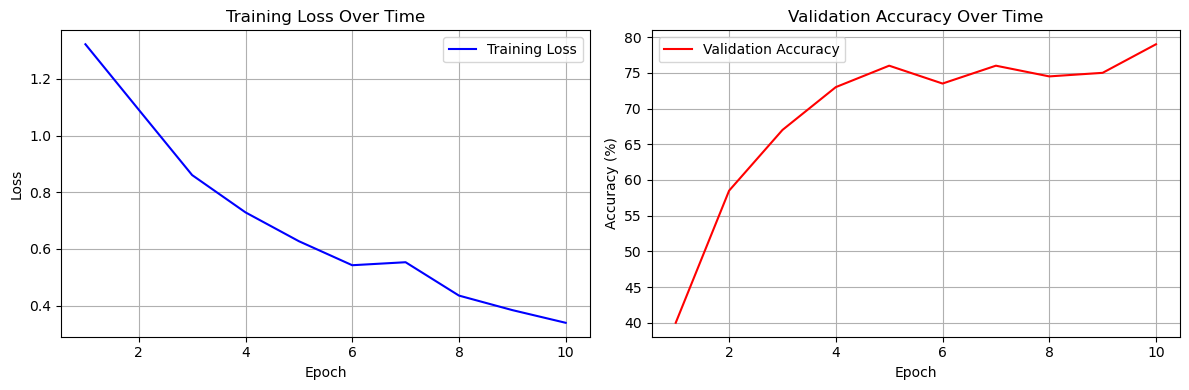

In [9]:
# Plot training progress
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
ax1.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Over Time')
ax1.legend()
ax1.grid(True)

# Plot validation accuracy
ax2.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Validation Accuracy Over Time')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 6. Training Results Visualization

In [10]:
# Final evaluation on validation set
model.eval()
correct = 0
total = 0
class_correct = list(0. for i in range(len(dataset.classes)))
class_total = list(0. for i in range(len(dataset.classes)))

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Calculate per-class accuracy
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print overall accuracy
print(f'Overall Validation Accuracy: {100 * correct / total:.2f}%')
print()

# Print per-class accuracy
print('Per-class Accuracy:')
for i, class_name in enumerate(dataset.classes):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'{class_name}: {accuracy:.2f}% ({int(class_correct[i])}/{int(class_total[i])})')
    else:
        print(f'{class_name}: N/A (no samples)')

Overall Validation Accuracy: 79.00%

Per-class Accuracy:
bird: 65.22% (30/46)
car: 84.09% (37/44)
fish: 77.78% (42/54)
flower: 87.50% (49/56)


## 7. Model Evaluation

Evaluate the trained model on the validation set and calculate:
- Overall accuracy
- Per-class accuracy

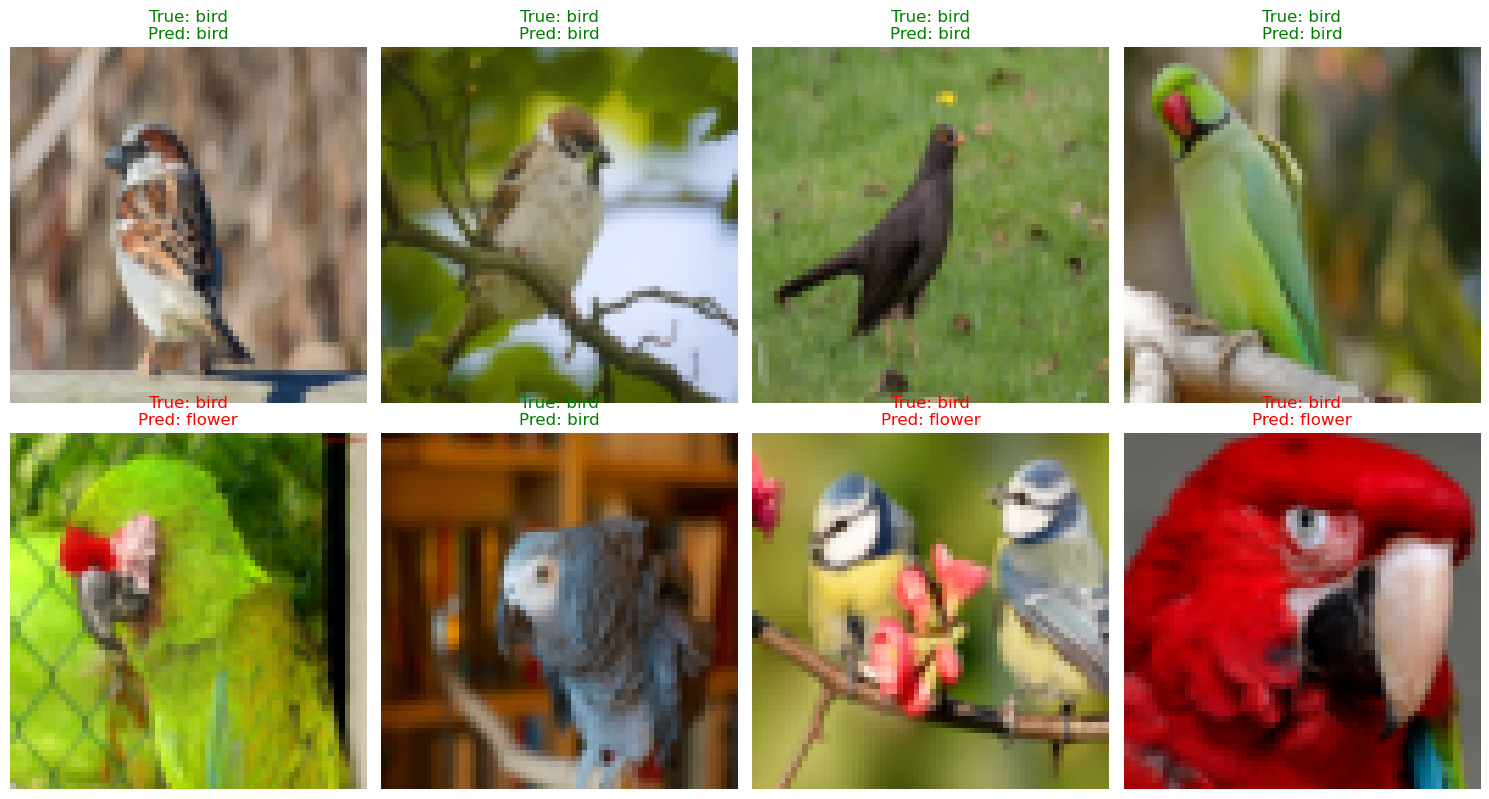

In [11]:
# Visualize some predictions
def visualize_predictions(model, dataloader, num_images=8):
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    # Get one batch of validation data
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Move images back to CPU for visualization
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()
    
    for i in range(min(num_images, len(images))):
        # Denormalize image for display
        img = images[i]
        # Reverse normalization
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose for matplotlib
        img = img.numpy().transpose((1, 2, 0))
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {dataset.classes[labels[i]]}\nPred: {dataset.classes[predicted[i]]}')
        axes[i].axis('off')
        
        # Color the title based on correctness
        if labels[i] == predicted[i]:
            axes[i].title.set_color('green')
        else:
            axes[i].title.set_color('red')
    
    plt.tight_layout()
    plt.show()

# Show sample predictions
visualize_predictions(model, val_loader)

## 8. Predictions Visualization

Visualize model predictions on sample images:
- Green titles: Correct predictions
- Red titles: Incorrect predictions